In [1]:
# import
import numpy as np
import pymc3 as pm
import arviz as az
from scipy.stats import norm
import scipy
from scipy.stats import halfnorm
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
np.set_printoptions(precision=3, suppress=True)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [204]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## for pymc3 GP model:

X: array-like
Function input values. If one-dimensional, must be a column vector with shape (n, 1).

y: array-like
Data that is the sum of the function with the GP prior and Gaussian noise. Must have shape (n, ).

# Exp 1: Degree in polynomial models

In [150]:
np.random.seed(456)
p_true = [3, 0.3, 1.5, -1.2] 
def f(x): return np.polyval(p_true, x) 
def noise(y): return y + np.random.normal(size=y.shape) * 100

In [151]:
model_x = np.linspace(-10,10,500)
model_y = f(model_x)

In [152]:
# observation
x0 = 20 * np.random.random_sample(size = 30) -10
y0 = noise(f(x0))
print(y0)

[ -371.025  -801.522   433.693   696.856   138.532  -113.679  1537.806
   348.863  -709.847 -1015.882    26.479  -160.555    24.21  -1096.542
   284.488   -56.856     8.545    50.825   317.774   269.839  -776.624
 -1286.783  -512.741 -2835.311  -190.153 -1150.774   126.847  1109.821
  -709.725 -1165.332]


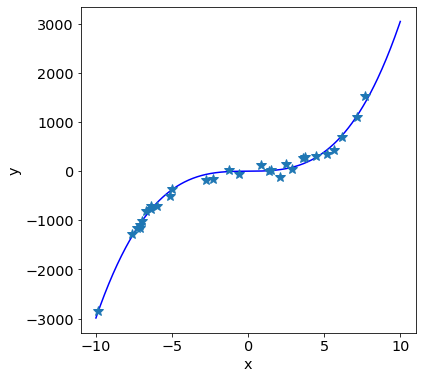

In [231]:
plt.plot(model_x,model_y, 'b')
plt.plot(x0, y0, '*', markersize = 10)
plt.xlabel("x")
plt.ylabel('y')
plt.savefig('poly_data')
plt.show()

In [7]:
from sklearn.linear_model import Lasso

In [154]:
clf = Lasso(alpha = 100)
X = np.stack([model_x**i for i in range(5)],-1)
X0 = np.stack([x0**i for i in range(5)],-1)
clf.fit(X0, y0)
y_fit_reg = clf.predict(X)
err_reg = np.sqrt(np.mean((model_y-y_fit_reg)**2))/np.std(model_y)
print(err_reg)

0.030637641503600276


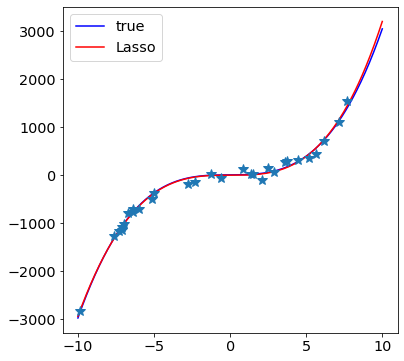

In [232]:
plt.plot(model_x, model_y, 'b', label = 'true')
plt.plot(model_x, y_fit_reg, 'r', label = 'Lasso')
plt.plot(x0, y0, '*', markersize = 10)
plt.legend()
plt.savefig('poly_data')
plt.show()

In [76]:
# target function: 
def error(P):
    beta = np.polyfit(x0, y0, P)
    y_pred = np.polyval(beta, model_x)
    err = np.sqrt(np.mean((y_pred-model_y)**2))/np.std(model_y)
    return err

In [156]:
p_guess = [2, 5, 7]
errors = []
for i in range(len(p_guess)):
    errors.append(error(p_guess[i]))

In [157]:
print(errors)

[0.5025258390988723, 0.16498678106297376, 0.3904210922505548]


In [158]:
Var_f = np.std(errors)**2
print(Var_f)

0.019702302069589575


In [162]:
x_dim = 1
X = np.array(p_guess).reshape(-1,x_dim)
y = (errors + np.random.normal(scale = np.sqrt(Var_f)/100, size = len(p_guess))).reshape(-1,)
Var_y = np.std(y)**2
Var_n = Var_y-Var_f

y_best_0 = np.min(y)
print(X.shape, y.shape)

print("Function value of current best is", y_best_0, "when x =", X[np.argmin(y)])
print("Total variance of y:", Var_y)
print("Variance from noise in y:", Var_n)
print("Variance from target function:", Var_f)

(3, 1) (3,)
Function value of current best is 0.163797457745477 when x = [5]
Total variance of y: 0.020018093149800995
Variance from noise in y: 0.00031579108021142013
Variance from target function: 0.019702302069589575


In [169]:
# clue for sigma in covariance function
np.sqrt(np.sqrt(Var_f))

0.37465302483761403

In [165]:
np.sqrt(Var_f)/np.sqrt(Var_n)

7.8987534345558545

In [166]:
# clue for ls
np.std(X)/10

0.20548046676563256

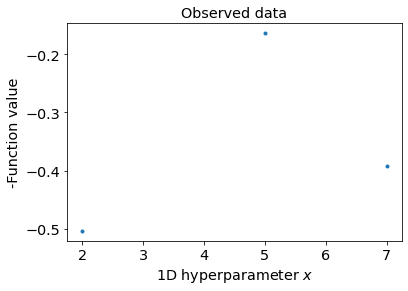

In [167]:
plt.plot(X, -y, '.')
plt.xlabel('1D hyperparameter $x$')
plt.ylabel('-Function value')
plt.title('Observed data')
plt.savefig('observed_poly')
plt.show()

## Gaussian process

In [168]:
# Transform data shape and sign of y for pm.Model
X_1 = X.reshape(-1,x_dim)
y_1 = -y.flatten()
print(X_1.shape, y_1.shape)

(3, 1) (3,)


In [170]:
# gaussian process model
def gp_model(X, y, x_dim, alpha, beta, noise, n_iter):
    with pm.Model() as poly_model:
        # specify covariance function
        sigma = pm.Gamma('sigma', alpha = alpha[0], beta = beta[0])
        ls = pm.Gamma('ls', alpha = alpha[1], beta = beta[1])
        K = sigma**2 * pm.gp.cov.Matern52(input_dim = x_dim, ls = ls)
        # assume mean function is 0
        M = pm.gp.mean.Zero()
        gp = pm.gp.Marginal(cov_func = K)
        noise = pm.HalfNormal('noise', sigma = noise)
    
        y_ = gp.marginal_likelihood('y', X = X, y = y, noise = noise)
        # posterior sampling
        start = pm.find_MAP()
        step = pm.Slice()
        slice_idata = pm.sample(n_iter, start = start, step = step, chains = 1)
    pm.traceplot(slice_idata)
    return slice_idata

/var/folders/r5/q1crcdpn2pq1t0qkh34h6whx0pw5l1/T/ipykernel_24453/697465963.py:17: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  slice_idata = pm.sample(n_iter, start = start, step = step, chains = 1)
/Applications/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Slice: [noise]
>Slice: [ls]
>Slice: [sigma]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/var/folders/r5/q1crcdpn2pq1t0qkh34h6whx0pw5l1/T/ipykernel_24453/697465963.py:18: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(slice_idata)
/Applications/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


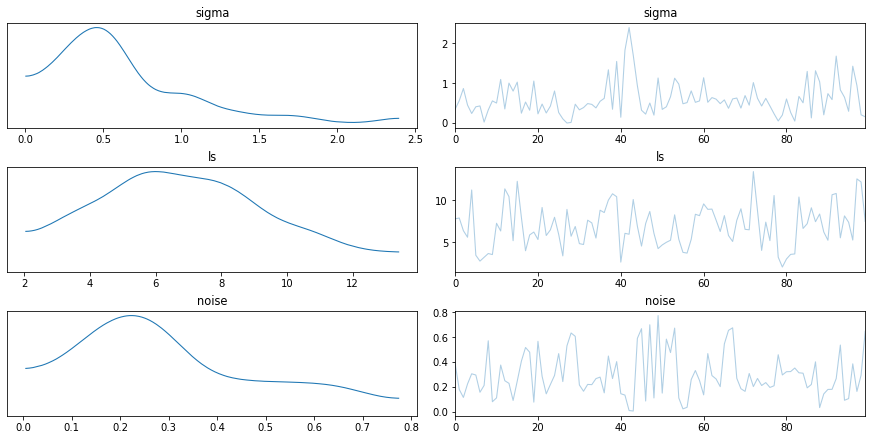

In [173]:
slice_idata_1 = gp_model(X_1, y_1, x_dim, alpha = [1, 7,5], beta = [0.5, 1], noise = 0.4, n_iter = 100)

In [89]:
# use samples to infer predictive mean and variance
def predict(x_eval, slice_idata, sample_start, n_iter):
    sigma_sample = slice_idata["sigma"]
    ls_sample = slice_idata["ls"]
    noise_sample = slice_idata["noise"]
    pred_mus = []
    pred_sds = []

    for t in range(sample_start, n_iter):
        params = {"sigma": sigma_sample[t], "ls": ls_sample[t], "noise": noise_sample[t]}
        mu, var = gp.predict(x_eval, point=params, diag=True)
        sd = np.sqrt(var)
        pred_mus.append(mu)
        pred_sds.append(sd)
    pred_mu = np.stack(pred_mus)
    pred_sd = np.stack(pred_sds)
    return pred_mu, pred_sd

In [174]:
x_eval_1 = np.array([3, 6]).reshape(-1,x_dim)
pred_mu_1, pred_sd_1 = predict(x_eval = x_eval_1, slice_idata = slice_idata_1, sample_start = 80, n_iter = n_iter)

/var/folders/r5/q1crcdpn2pq1t0qkh34h6whx0pw5l1/T/ipykernel_24453/3736024598.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


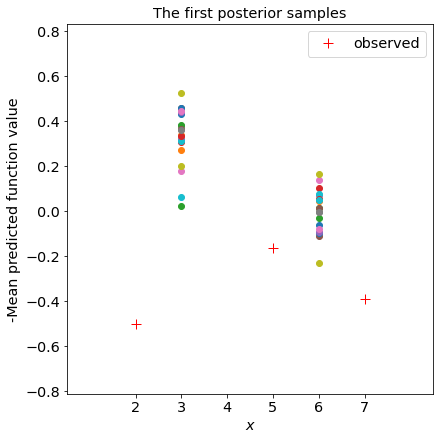

In [225]:
fig, ax = plt.subplots(layout="constrained")
for t in range(pred_mu_1.shape[0]):
    ax.scatter(x_eval_1, pred_mu_1.T[:,t])
ax.set_xlabel('$x$')
ax.set_ylabel('-Mean predicted function value')
ax.set_title('The first posterior samples')
ax.set_xticks(np.array([2,3,4,5,6,7]).flatten())
ax.margins(0.3)
ax.plot(X, -y, 'r+', label = 'observed', ms = 10)
ax.legend()
plt.savefig('1st_pred_poly')
plt.show()

In [41]:
def acq_EI(y_best, pred_mu, pred_sd):
    gamma = (y_best-pred_sd)/pred_mu
    return pred_sd * (norm.cdf(gamma) * gamma + norm.pdf(gamma))

In [42]:
def acq_PI(y_best, pred_mu, pred_sd):
    gamma = (y_best-pred_sd)/pred_mu
    return norm.cdf(gamma)

In [43]:
def acq_LCB(pred_mu, pred_sd, K):
    return pred_mu+K*pred_sd

In [44]:
def acq_dataset(y_best, pred_mu, pred_sd, K):
    acq_EIs = []
    acq_PIs = []
    acq_LCBs = []
    for t in range(pred_mu.shape[0]):
        acq_EIs.append(acq_EI(y_best = y_best, pred_mu = pred_mu.T[:,t], pred_sd = pred_sd.T[:,t]))
        acq_PIs.append(acq_PI(y_best = y_best, pred_mu = pred_mu.T[:,t], pred_sd = pred_sd.T[:,t]))
        acq_LCBs.append(acq_LCB(pred_mu = pred_mu.T[:,t], pred_sd = pred_sd.T[:,t], K=K))
    acq_EI_data = np.stack(acq_EIs)
    acq_PI_data = np.stack(acq_PIs)
    acq_LCB_data = np.stack(acq_LCBs)
    return acq_EI_data, acq_PI_data, acq_LCB_data

In [177]:
acq_EI_data_1, acq_PI_data_1, acq_LCB_data_1 = acq_dataset(-y_best, pred_mu_1, pred_sd_1, K = 0.5)

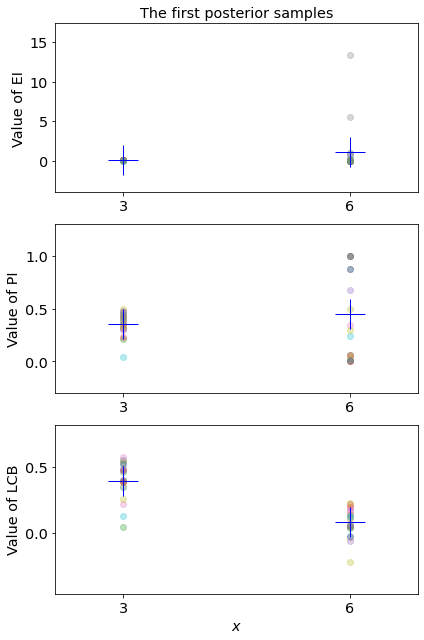

[0.396 0.08 ]
[0.357 0.45 ]
[0.029 1.11 ]


In [219]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, figsize=(6, 9))
for t in range(acq_EI_data_1.shape[0]):
    ax1.scatter(x_eval_1, acq_EI_data_1[t,:], alpha = 0.3)
ax1.plot(x_eval_1, np.sum(acq_EI_data_1, axis=0)/acq_EI_data_1.shape[0], 'b+', markersize =30)
ax1.set_ylabel("Value of EI")
ax1.set_title("The first posterior samples")
ax1.set_xticks(x_eval_1.flatten())
ax1.margins(0.3)

for t in range(acq_PI_data_1.shape[0]):
    ax2.scatter(x_eval_1, acq_PI_data_1[t,:], alpha = 0.3)
ax2.plot(x_eval_1, np.sum(acq_PI_data_1, axis=0)/acq_PI_data_1.shape[0], 'b+', markersize =30)
ax2.set_ylabel("Value of PI")
ax2.set_xticks(x_eval_1.flatten())
ax2.margins(0.3)

for t in range(acq_LCB_data_1.shape[0]):
    ax3.scatter(x_eval_1, acq_LCB_data_1[t,:], alpha = 0.3)
ax3.plot(x_eval_1, np.sum(acq_LCB_data_1, axis=0)/acq_LCB_data_1.shape[0], 'b+', markersize =30)
ax3.set_xlabel("$x$")
ax3.set_ylabel("Value of LCB")
ax3.set_xticks(x_eval_1.flatten())
ax3.margins(0.3)

plt.tight_layout()
plt.savefig('Acq_1st_post_sample.png', bbox_inches='tight')
plt.show()

print(np.sum(acq_LCB_data_1, axis=0)/acq_LCB_data_1.shape[0])
print(np.sum(acq_PI_data_1, axis=0)/acq_PI_data_1.shape[0])
print(np.sum(acq_EI_data_1, axis=0)/acq_EI_data_1.shape[0])

In [184]:
y_best_1 = error(6)
print(y_best_1)

0.29803918281826375


In [185]:
y_1

array([-0.504, -0.164, -0.392])

In [113]:
# data for gp
def data_gp(x_current, y_current, x_update, y_best_update):
    X = np.append(x_current, x_update).reshape(-1,x_dim)
    y = np.append(y_current, -y_best_update).flatten()
    print(X.shape, y.shape)
    return X, y

In [186]:
X_2, y_2 = data_gp(x_current = X_1, y_current = y_1, x_update = 6, y_best_update = y_best_1)
print(y_2)

(4, 1) (4,)
[-0.504 -0.164 -0.392 -0.298]


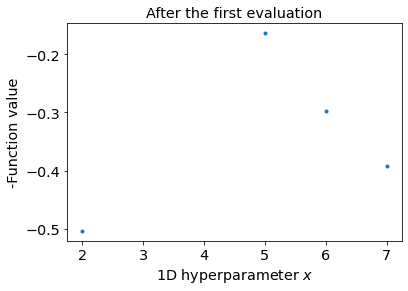

In [197]:
plt.plot(X_2, y_2, '.')
plt.xlabel('1D hyperparameter $x$')
plt.ylabel('-Function value')
plt.title('After the first evaluation')
plt.savefig('error_after_1st')
plt.show()

/var/folders/r5/q1crcdpn2pq1t0qkh34h6whx0pw5l1/T/ipykernel_24453/697465963.py:17: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  slice_idata = pm.sample(n_iter, start = start, step = step, chains = 1)
/Applications/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Slice: [noise]
>Slice: [ls]
>Slice: [sigma]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/var/folders/r5/q1crcdpn2pq1t0qkh34h6whx0pw5l1/T/ipykernel_24453/697465963.py:18: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(slice_idata)
/Applications/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


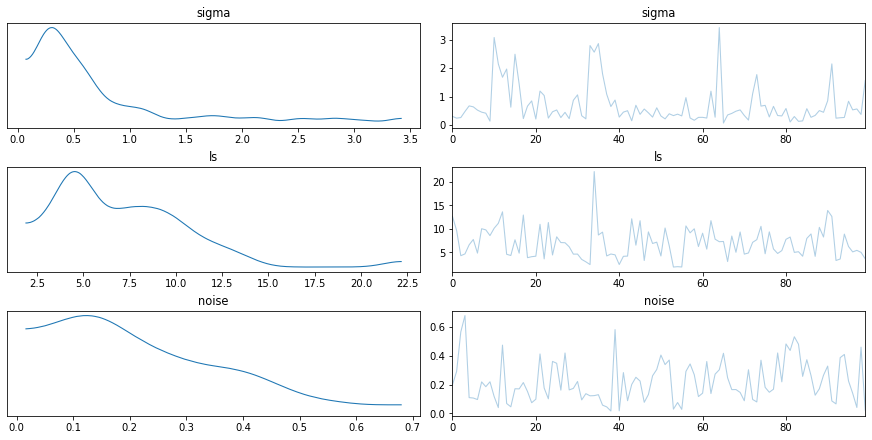

In [188]:
slice_idata_2 = gp_model(X_2, y_2, x_dim, alpha = [1, 7,5], beta = [0.5, 1], noise = 0.4, n_iter = 100)

In [189]:
x_eval_2 = np.array([3, 4]).reshape(-1,x_dim)
pred_mu_2, pred_sd_2 = predict(x_eval = x_eval_2, slice_idata = slice_idata_2, sample_start = 80, n_iter = n_iter)

/var/folders/r5/q1crcdpn2pq1t0qkh34h6whx0pw5l1/T/ipykernel_24453/3010756679.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


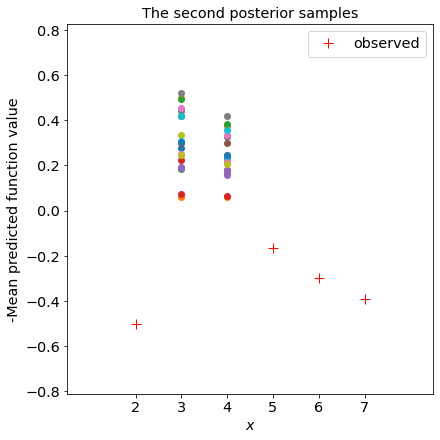

In [227]:
fig, ax = plt.subplots(layout="constrained")
for t in range(pred_mu_2.shape[0]):
    ax.scatter(x_eval_2, pred_mu_2.T[:,t])
ax.set_xlabel('$x$')
ax.set_ylabel('-Mean predicted function value')
ax.set_title('The second posterior samples')
ax.set_xticks(np.array([2,3,4,5,6,7]).flatten())
ax.margins(0.3)
ax.plot(X_2, y_2, 'r+', label = 'observed', ms = 10)
ax.legend()
plt.savefig('2nd_pred_poly')
plt.show()

In [190]:
acq_EI_data_2, acq_PI_data_2, acq_LCB_data_2 = acq_dataset(-y_best_1, pred_mu_2, pred_sd_2, K = 0.5)

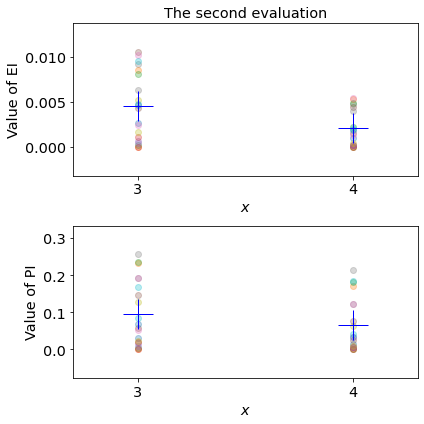

[0.096 0.065]
[0.005 0.002]


In [229]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
for t in range(acq_EI_data_2.shape[0]):
    ax1.scatter(x_eval_2, acq_EI_data_2[t,:], alpha = 0.3)
ax1.plot(x_eval_2, np.sum(acq_EI_data_2, axis=0)/acq_EI_data_2.shape[0], 'b+', markersize =30)
ax1.set_xlabel("$x$")
ax1.set_ylabel("Value of EI")
ax1.set_title("The second evaluation")
ax1.set_xticks(x_eval_2.flatten())
ax1.margins(0.3)

for t in range(acq_PI_data_2.shape[0]):
    ax2.scatter(x_eval_2, acq_PI_data_2[t,:], alpha = 0.3)
ax2.plot(x_eval_2, np.sum(acq_PI_data_2, axis=0)/acq_PI_data_2.shape[0], 'b+', markersize =30)
ax2.set_xlabel("$x$")
ax2.set_ylabel("Value of PI")
ax2.set_xticks(x_eval_2.flatten())
ax2.margins(0.3)

plt.tight_layout()
plt.savefig('Acq_2nd_post_sample.png', bbox_inches='tight')
plt.show()

print(np.sum(acq_PI_data_2, axis=0)/acq_PI_data_2.shape[0])
print(np.sum(acq_EI_data_2, axis=0)/acq_EI_data_2.shape[0])

In [201]:
y_best_2 = error(3)
print(y_best_2)

0.016375190138860476


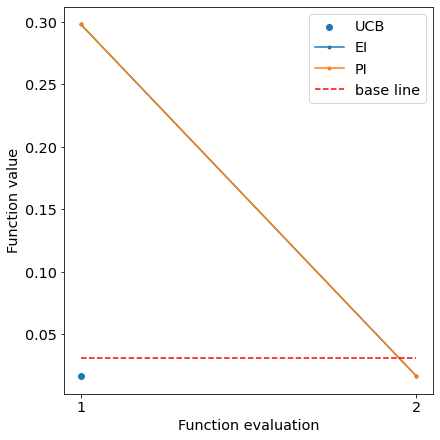

In [230]:
fig, ax = plt.subplots(layout="constrained")
ax.scatter(1, y_best_2, label = 'UCB')
ax.plot([1, 2], [y_best_1, y_best_2], '.-', label = 'EI')
ax.plot([1, 2], [y_best_1, y_best_2], '.-', label = 'PI')
ax.hlines(y=err_reg, xmin = 1, xmax = 2, colors = 'r', linestyles = 'dashed', label = 'base line')
ax.set_xlabel('Function evaluation')
ax.set_ylabel('Function value')
ax.set_title('')
ax.set_xticks([1, 2])
ax.legend()

plt.savefig('summary')
plt.show()